# General setting

In [ ]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive/',force_remount=True)
sys.path.insert(0,'/content/drive/MyDrive/BackUp_RL_CodeBase')
os.chdir('/content/drive/MyDrive/BackUp_RL_CodeBase/')
os.getcwd()

Mounted at /content/drive/


'/content/drive/MyDrive/BackUp_RL_CodeBase'

In [ ]:
import pandas as pd
import numpy as np
from helpers.helperFunction import data_split,splitByRatio

In [ ]:
# read inputs
df_price = pd.read_csv('Input/B_priceClean.csv')
# factset
raw_mc = pd.read_excel('Input/Eurostoxx50_MC.xlsx',sheet_name ="MarketCap",index_col='Date')
raw_fs_price = pd.read_excel("Input/Eurostoxx50_Adjc.xlsx",sheet_name ="Close",index_col='Date')
# tickers
mapping = pd.read_excel("Input/Universe.xlsx",sheet_name ="Factset-YF-Mapping")

In [ ]:
def port_Value(returns, start):
    """
    Takes a timeseries of asset returns
    Computes and returns a Dataframe that contains:
    the wealth index
    the previous peaks
    percent drawdowns
    """
    returns = returns.iloc[:,0]
    wealth_index = start*(1+returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_index,
        "Peaks": previous_peaks,
        "Drawdown": drawdowns
    }, index=returns.index)

In [ ]:
# split price to the test period
test = data_split(df_price, '2002-12-31','2021-12-31')

# Equal Weighted

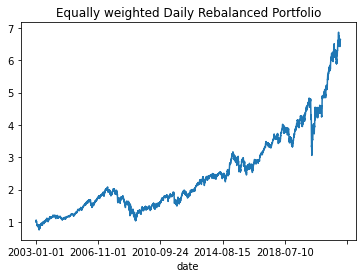

In [ ]:
# Value of an equally weighted portfolio is the sum of the stocks, portfolio return is pct_change
eq_val = test.pivot(index='date',columns='tic',values='close').sum(axis=1)
eq_perc = eq_val.pct_change(periods=1).dropna()
df_eq = pd.DataFrame({'perc':eq_perc})
df_port_ret_eq = port_Value(df_eq,start=1)
df_port_ret_eq.Wealth.plot(title='Equally weighted Daily Rebalanced Portfolio')

In [ ]:
df_out_eq = pd.DataFrame({'value':eq_val, 'Port_Return' :eq_perc})
df_out_eq = df_out_eq.merge(df_port_ret_eq, how='inner', right_index=True, left_index=True)
#export equal weighted
df_out_eq.to_csv('benchmark_results/EQ.csv',index=True, index_label='date')

In [ ]:
# pd.read_csv('benchmark_results/EQ.csv',index_col='date')

# Market Cap Weighted

## Cleaning

In [ ]:
# map ticker name for price data as well as for market cap
# if the columns are all in the same sequence, we will rename the columns directly with YF tickers create new dataframe call rn_fs
mappingFCYF = mapping[['Ticker','YFTicker']] # columns for mapping
# price data
if (raw_fs_price.columns == mappingFCYF.Ticker).all(): 
  rn_fp = raw_fs_price.copy()
  rn_fp.columns = mappingFCYF.YFTicker

# market cap data
if (raw_mc.columns == mappingFCYF.Ticker).all(): 
  rn_mc = raw_mc.copy()
  rn_mc.columns = mappingFCYF.YFTicker


In [ ]:
# clean price
# reduce tickers 
ls_Remaintick = df_price.tic.unique()
cleaned_mc = rn_mc[ls_Remaintick]
cleaned_fp = rn_fp[ls_Remaintick]

# change date format
# cleaned_fp date: str m/d/y -> y-m-d
temp = cleaned_fp.copy()
temp.index = pd.to_datetime(cleaned_fp.index,format ='%m/%d/%Y')
temp = temp.reset_index() # convert index to column
temp = temp.rename(columns = {'Date':'date'})
temp['date'] = temp['date'].dt.strftime('%Y-%m-%d') # convert to str
temp

# reduce dates
# construct a df with yfDates 
ls_date = test.date.unique()
df_new_p = pd.DataFrame({'date':ls_date})
df_new_p = df_new_p.merge(temp,left_on='date',right_on='date')
print(f'date reduced from {temp.shape[0]} to {df_new_p.shape[0]}')

date reduced from 5464 to 4867


In [ ]:
# clean market capitalization data: reduce tickers 
ls_Remaintick = df_price.tic.unique() # YFticker
cleaned_mc = rn_mc[ls_Remaintick] # subset universe

# change date format for mapping, cleaned_mc date: str m/d/y -> y-m-d
temp = cleaned_mc.copy()
temp.index = pd.to_datetime(cleaned_mc.index,format ='%m/%d/%Y')
temp = temp.reset_index() # convert index to column
temp = temp.rename(columns = {'Date':'date'})
temp['date'] = temp['date'].dt.strftime('%Y-%m-%d') # convert to str

# reduce dates for constructing a df with yfDates 
ls_date = test.date.unique()
df_mc = pd.DataFrame({'date':ls_date})
df_mc = df_mc.merge(temp, how='left',right_on='date',left_on='date')
df_mc = df_mc.fillna(method='ffill') # fill na with prev, NA comes from left join
print(f'date reduced from {temp.shape[0]} to {df_mc.shape[0]}')

date reduced from 5464 to 4895


## Compute market cap weight

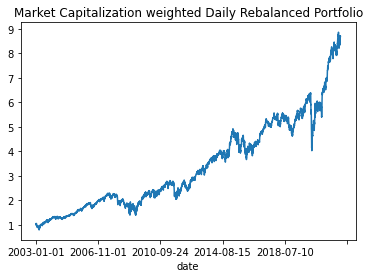

In [ ]:
# market cap weights
df_mc = df_mc.set_index('date') # reset index for the ease of calculation
ls_to_mc = (df_mc.sum(axis=1).tolist())
df_mc_wgt = df_mc.apply(lambda a: np.round(a/ls_to_mc,5))
df_mc_wgt = df_mc_wgt[1:] # reduce 1 row for pct

# return price individual
ret_tic = test.pivot(index='date',columns='tic',values='close').pct_change(periods=1).dropna()

# portfolio return market cap weighted
df_port_ret_mc = pd.DataFrame((df_mc_wgt * ret_tic).sum(axis=1))
df_out_mc = port_Value(df_port_ret_mc,start=1) 
df_out_mc['Port_Return'] = df_port_ret_mc
df_out_mc.Wealth.plot(title='Market Capitalization weighted Daily Rebalanced Portfolio')


In [ ]:
# export return
ret_tic.to_csv('benchmark_results/tic_pct.csv',index=True, index_label='date')
# export market cap weight
df_mc_wgt.to_csv('benchmark_results/wgt_mc.csv',index=True, index_label='date')
# market cap
df_out_mc.to_csv('benchmark_results/MC.csv',index=True, index_label='date')


In [ ]:
# ret_tic = pd.read_csv('benchmark_results/tic_pct.csv',index_col='date')
# df_mc_wgt = pd.read_csv('benchmark_results/wgt_mc.csv',index_col='date')
# df_out_mc = pd.read_csv('benchmark_results/MC.csv',index_col='date')